### Simple clustering example using the package

In [1]:
import numpy as np
from matplotlib import pyplot as plt

Importing the package main class, and the Normal Inverse Wishart (NIW) prior.

Follow the installation guide at: https://github.com/BGU-CS-VIL/DPMMPython before importing. Extra steps are required after `pip install`.

In [2]:
from julia.api import Julia
jl = Julia(compiled_modules=False)

from dpmmpython.dpmmwrapper import DPMMPython
from dpmmpython.priors import niw

### Data Generation

We will use the package data generation function to generate some 2D data

In [3]:
D = 2 # Dimension
K = 20 # Number of Clusters
N = 20000 #Number of points
var_scale = 100.0 # The variance of the MV-Normal distribution where the clusters means are sampled from.
data, labels = DPMMPython.generate_gaussian_data(N, D, K, var_scale)
print(data.shape)

(2, 20000)


Plotting the data

Note that as Julia is a column first language, the data generated is $DxN$

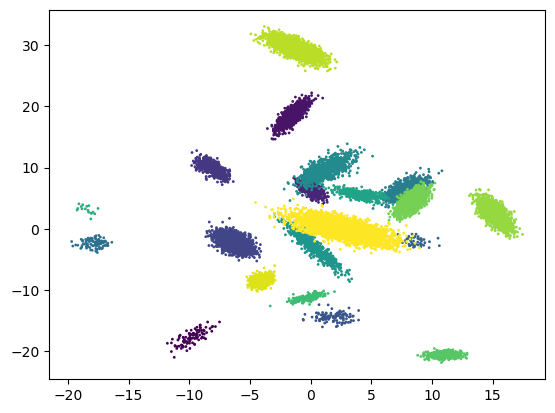

In [4]:
plt.scatter(data[0,:],data[1,:],c=labels, s=1)

### Fiting DPGMM Model to the data

Start by defining a niw prior and $\alpha$

In [5]:
prior = niw(1,np.zeros(D),2,np.eye(D)*0.5)
alpha = 10.0

Fit the model and store the results in `results`.
When working from Jupyter Notebook/Lab you will not see Julia prints. However when running python from terminal you will see all the prints (as in the Julia packages)

In [6]:
results = DPMMPython.fit(data,alpha,prior = prior,iterations=70, burnout=5,smart_splits=False)

The returned object is a tuple with  `(labels, cluster_distribution,sub_labels)`, we will only require the first item

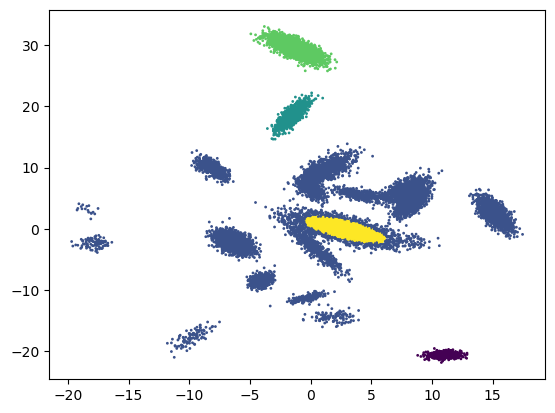

In [7]:
inferred_labels = results[0]
plt.scatter(data[0,:],data[1,:],c=inferred_labels, s=1)

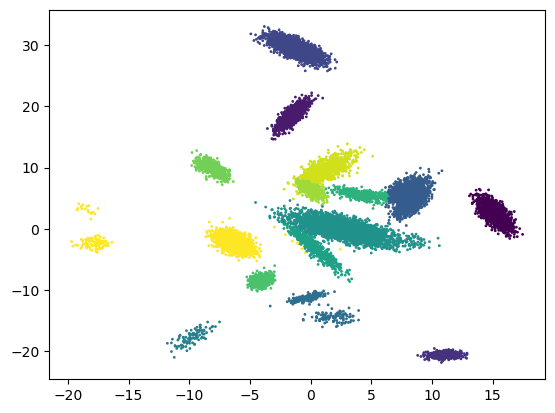

In [8]:
results = DPMMPython.fit(data,alpha,prior = prior,iterations=70, burnout=5,smart_splits=True)
inferred_labels = results[0]
plt.scatter(data[0,:],data[1,:],c=inferred_labels, s=1)

Looks good, we can quantilize the quality of the clustering using NMI:

In [9]:
from sklearn.metrics.cluster import normalized_mutual_info_score

In [10]:
dpgmmm_nmi = normalized_mutual_info_score(inferred_labels.astype(int), np.array(labels),average_method='arithmetic')
print(f'DPGMM NMI:{dpgmmm_nmi}')                                          

DPGMM NMI:0.9588477207361055


### Comparing VS other methods

In [11]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

#### K-means:

In [16]:
kmeans = KMeans(n_clusters=K).fit(data.T)
kmeans_labels = kmeans.labels_

C:\devTools\anaconda\envs\VosMini\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

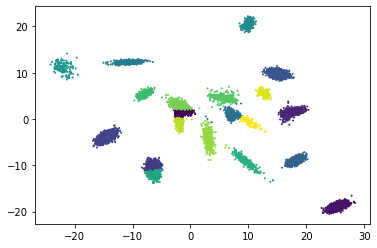

In [14]:
plt.scatter(data[0,:],data[1,:],c=kmeans_labels, s=1)

In [15]:
kmeans_nmi = normalized_mutual_info_score(kmeans_labels.astype(int), np.array(labels),average_method='arithmetic')
print(f'K-means NMI:{kmeans_nmi}')      

K-means NMI:0.9309229767796119


#### GMM:

In [14]:
gmm = GaussianMixture(n_components=20,covariance_type='full').fit(data.T)
gmm_labels = gmm.predict(data.T)

AttributeError: 'NoneType' object has no attribute 'split'

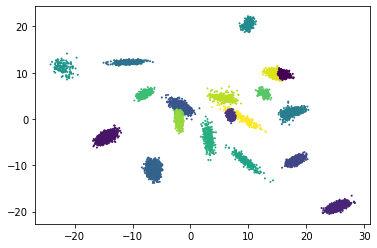

In [17]:
plt.scatter(data[0,:],data[1,:],c=gmm_labels, s=1)

In [18]:
gmm_nmi = normalized_mutual_info_score(gmm_labels.astype(int), np.array(labels),average_method='arithmetic')
print(f'GMM NMI:{gmm_nmi}')  

GMM NMI:0.9513343588873828


Even when using the correct K for K-means and GMM, the DPGMM outperform them.